# Competitive Pokemon Analysis

While in the traditional pokemon games, players raise Pokemon to complete an adventure, competitive Pokemon is a game where players strategically construct teams of pokemon with moves, natures, items, etc of their choosing to beaet other live players.  Not all Pokemon are equal for this purpose, so based on the usage statistics of the pokemon in competitive play, they are split into various tiers. A player may use a Pokemon to compete in a particular tier if the pokemon is in that tier or below. Historically, usage of various pokemon has changed overtime with the introduction of new pokemon, moves, abilities, and mechanics. So, Pokemon are constantly shifted between tiers to maintain balance.

In this analysis, we will attempt to classify pokemon into the competitive 6v6 tiers based on the properties of the Pokemon themselves.

## Data Processing

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

original = pd.read_csv('pokemon-data.csv', delimiter=';')
mdf = pd.read_csv('move-data.csv', delimiter=';')

print('Number of pokemon: ', len(df))
original.sample()

Number of pokemon:  569


,Name,Types,Abilities,Tier,HP,Attack,Defense,Special Attack,Special Defense,Speed,Next Evolution(s),Moves
907,Woobat,"['Flying', 'Psychic']","['Klutz', 'Simple', 'Unaware']",LC,65,45,43,55,43,72,['Swoobat'],"['Confusion', 'Odor Sleuth', 'Gust', 'Assuranc..."


As of generation 7, there are 8 playable tiers. From strongest to weakest: Anything Goes (AG), Uber, Overused (OU), Underused (UU), Rarelyused (RU), Neverused (NU), Partiallyused (PU) and Little Cup (LC). There are also unplayable tiers called borderline tiers, suffixed by BL. These serve as banlists for their respective tiers (so these pokemon can only be used in higher tiers). For the purpose of this analysis, we will classify BL pokemon as the tier above.

We will not consider the Little Cup (LC) format, as they are not defined by usage statistics (it involves pokemon that are not evolved but are capable of evolution and can be obtained in the traditional games at level 5). We will also discard the AG tier, as it was created solely for Mega Rayquaza. Both Pokemon that belong to no tier because they are uncompetitive and pokemon in the Limbo tier becuase they are unreleased will not be considererd.

Let's make these changes.

Total number of Pokemon:  569


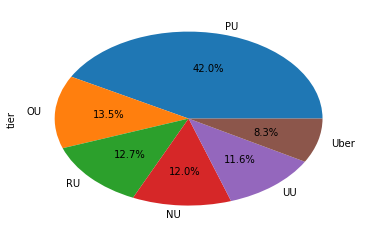

In [257]:
original.columns = ['name', 'types', 'abilities', 'tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'next_evo','moves']

df = original.copy()
df.loc[df.tier == 'OUBL','tier'] = 'Uber'
df.loc[df.tier == 'UUBL','tier'] = 'OU'
df.loc[df.tier == 'RUBL','tier'] = 'UU'
df.loc[df.tier == 'NUBL','tier'] = 'RU'
df.loc[df.tier == 'PUBL','tier'] = 'NU'
df = df[df['tier'].isin(['Uber', 'OU', 'UU', 'NU', 'RU', 'PU'])]

ax = df.tier.value_counts().plot(kind='pie', autopct='%1.1f%%')
print('Total number of Pokemon: ', len(df))

All the upper tiers are similar in size by design, but the PU tier is a dump of all the least used pokemon. We must account for this later. 

The base stat total is a common metric players use to assess a Pokemon's overall strength, so let's create a column for this.

In [258]:
df['bst'] = df['hp'] + df['atk'] + df['def'] + df['spa'] + df['spd'] + df['spe']
df = df[['name', 'types', 'abilities', 'tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'bst', 'next_evo','moves']]
df.sample()

,name,types,abilities,tier,hp,atk,def,spa,spd,spe,bst,next_evo,moves
439,Lumineon,['Water'],"['Storm Drain', 'Swift Swim', 'Water Veil']",PU,69,69,76,69,86,91,460,[],"['Soak', 'Gust', 'Pound', 'Water Gun', 'Attrac..."


The next evolution information is not immediately useful; however, we can determine how far a pokemon is in it's evolutionary chain. Notice that a pokemon can have one, two, or three evolutions in it's chain, along with the possibility of a mega evolution. A pokemon that is in its final form that after one evolution is not necessarily weaker or stronger than another after two evolutions. For each pokemon, let's store the length of the evolutionary chain (excluding mega evolutions) and it's stage in the chain. 

A mega evolution will be the stage of the pokemon + 1. For example, Blaziken would have a chain length of 3 and it would be in stage 3, while Mega Blaziken would have a chain length of 3 and it would be in stage 4.

In [418]:
def stage_in_evo(name):
    # returns number of evolutions before it
    bool_arr = original.apply(lambda x: name in x['next_evo'] and name != x['name'], axis=1) #gets index of previous evolution
    if not any(bool_arr):
        return 1 # if there's nothing before it, it's the first
    #if name.find('-')
    else:
        return 1 + stage_in_evo(original.loc[bool_arr, 'name'].values[0])
    
df['stage'] = stage_in_evo(df['name'].values[0])
original['stage'] = stage_in_evo(original['name'].values[0])
df.sample()

,name,types,abilities,tier,hp,atk,def,spa,spd,spe,bst,next_evo,moves,stage
486,Meloetta,"['Normal', 'Psychic']",['Serene Grace'],RU,100,77,77,128,128,90,600,[],"['Round', 'Quick Attack', 'Confusion', 'Sing',...",2


In [470]:
original[original['name'] == 'Deoxys']

,name,types,abilities,tier,hp,atk,def,spa,spd,spe,next_evo,moves,stage
170,Deoxys,['Psychic'],['Pressure'],Uber,50,150,50,150,50,150,[],"['Leer', 'Wrap', 'Night Shade', 'Teleport', 'K...",2


In [459]:
#original['name'].values
temp = original.loc[original.apply(lambda x: x['name'].find('-') != -1 and x['name'].find('Mega')==-1, axis =1)]
with pd.option_context("display.max_rows", 1000):
    display(temp)
    #print(name + ' Prev: ' + temp.loc[temp.apply(lambda x: name in x['next_evo'] and name != x['name'], axis=1), 'name'].values)

,name,types,abilities,tier,hp,atk,def,spa,spd,spe,next_evo,moves,stage
7,Aegislash-Blade,"['Steel', 'Ghost']",['Stance Change'],Uber,60,150,50,150,50,60,[],"['Fury Cutter', 'Pursuit', 'Autotomize', 'Shad...",2
160,Darmanitan-Zen,"['Fire', 'Psychic']",['Zen Mode'],UU,105,30,105,140,105,55,[],"['Tackle', 'Rollout', 'Incinerate', 'Hammer Ar...",2
171,Deoxys-Attack,['Psychic'],['Pressure'],Uber,50,180,20,180,20,150,[],"['Leer', 'Wrap', 'Night Shade', 'Teleport', 'T...",2
172,Deoxys-Defense,['Psychic'],['Pressure'],Uber,50,70,160,70,160,90,[],"['Leer', 'Wrap', 'Night Shade', 'Teleport', 'K...",2
173,Deoxys-Speed,['Psychic'],['Pressure'],Uber,50,95,90,95,90,180,[],"['Leer', 'Wrap', 'Night Shade', 'Double Team',...",2
183,Diglett-Alola,"['Ground', 'Steel']","['Sand Force', 'Sand Veil', 'Tangling Hair']",LC,10,55,30,35,45,90,['Dugtrio-Alola'],"['Sand Attack', 'Metal Claw', 'Growl', 'Astoni...",2
202,Dugtrio-Alola,"['Ground', 'Steel']","['Sand Force', 'Sand Veil', 'Tangling Hair']",PU,35,100,60,50,70,110,[],"['Sand Tomb', 'Sand Tomb', 'Rototiller', 'Nigh...",2
231,Exeggutor-Alola,"['Grass', 'Dragon']","['Frisk', 'Harvest']",PU,95,105,85,125,75,45,[],"['Dragon Hammer', 'Dragon Hammer', 'Seed Bomb'...",2
248,Floette-Eternal,['Fairy'],"['Flower Veil', 'Symbiosis']",Limbo,74,65,67,125,128,92,[],"['Tackle', 'Vine Whip', 'Fairy Wind', 'Fairy W...",2
276,Geodude-Alola,"['Rock', 'Electric']","['Galvanize', 'Magnet Pull', 'Sturdy']",LC,40,80,100,30,30,20,['Graveler-Alola'],"['Tackle', 'Defense Curl', 'Charge', 'Rock Pol...",2
